# Explicit Heat in 1d with cure

In [2]:
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np

In [3]:
Hein_2018 = dict(Tg0=-16.8, Tg8=225, lam=.543,    # DiBenedetto
                a=.04, b=3.93,                    # X_max
                A1=np.exp(11.149), EA1=75549,     # Cure model parameters
                A2=np.exp(8.762), EA2=50911, 
                l=.489, m=1.549, n=2.179,
                Hr=490e3                         # Enthalpy [J / kg]
                )
#### Constants
kelvin = 273.15
R = 8.314472

In [4]:
def calc_X_max(temp, model_parameters): 
    """Calculate maximum attainable degree of cure depending on cure temperature"""
    a = model_parameters["a"]
    b = model_parameters["b"]
    return 1/(1+np.exp(-temp*a+b))
def arrhenius(A, E, T):
    """Calculate Arrhenius factor k"""
    return A*np.exp(-E / R / T)
def arrhenius_facors(temp, model_parameters):
    """Calculate both arrhenius factos k1 and k2 for temperature temp and the model"""
    T = temp + kelvin
    A1 = model_parameters["A1"]
    EA1 = model_parameters["EA1"]
    A2 = model_parameters["A2"]
    EA2 = model_parameters["EA2"]
    return arrhenius(A1, EA1, T), arrhenius(A2, EA2, T)
def reaction_model(X, temp, model_parameters):  
    """Calculate reaction rate, input function for numerical integration"""
    k1, k2 = arrhenius_facors(temp, model_parameters)
    max_X = calc_X_max(temp, model_parameters)
    m = model_parameters["m"]
    l = model_parameters["l"]
    n = model_parameters["n"]
    d_X = max_X - X
    d_X[d_X < 0] = 0
    return k1 * d_X**l + k2 * X**m * d_X**n

<IPython.core.display.Javascript object>


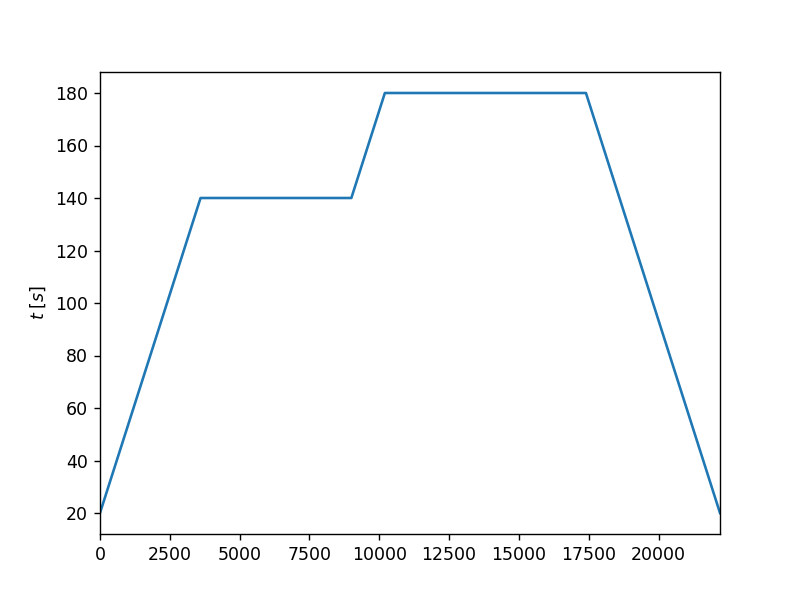

duration: 22200.0 s


In [5]:
def interpol_tempcycle(t, cycle):
    """Return temperature at time t in cycle by linear interpolation"""
    return np.interp(t, cycle[:,0], cycle[:,1])

#### Temperature Cycle
# start and end temperature [°C]
temp0 = 20
# temperature ramp [K/min]
ramp = 2
# first dwell temperature
temp1 = 140
# fist dwell duration [min]
duration1 = 90
# second dwell temperature
temp2 = 180
# second dwell duration
duration2 = 120

cycle = [[0, temp0]]
cycle.append([np.abs(temp1 - temp0)/ramp, temp1]) 
cycle.append([cycle[-1][0]+duration1, temp1])
cycle.append([np.abs(temp2 - temp1)/ramp + cycle[-1][0], temp2]) 
cycle.append([cycle[-1][0]+duration2, temp2]) 
cycle.append([np.abs(temp2 - temp0)/ramp + cycle[-1][0], temp0]) 

cycle = np.array(cycle)
cycle[:, 0] *= 60

plt.figure()
plt.plot(cycle[:, 0], cycle[:, 1])
plt.ylabel("$T \; [^\circ C]$")
plt.ylabel("$t \; [s]$")
plt.autoscale(axis="x", tight=True)

print("duration: {} s".format(cycle[-1, 0]))

k_mold = 1.172e-05 m^2 / K / s
k_comp = 3.436135050695024e-07 m^2 / K / s
rho_comp = 1425.0 kg / m^3
cp_comp = 807.859649122807 J / kg / K


<IPython.core.display.Javascript object>


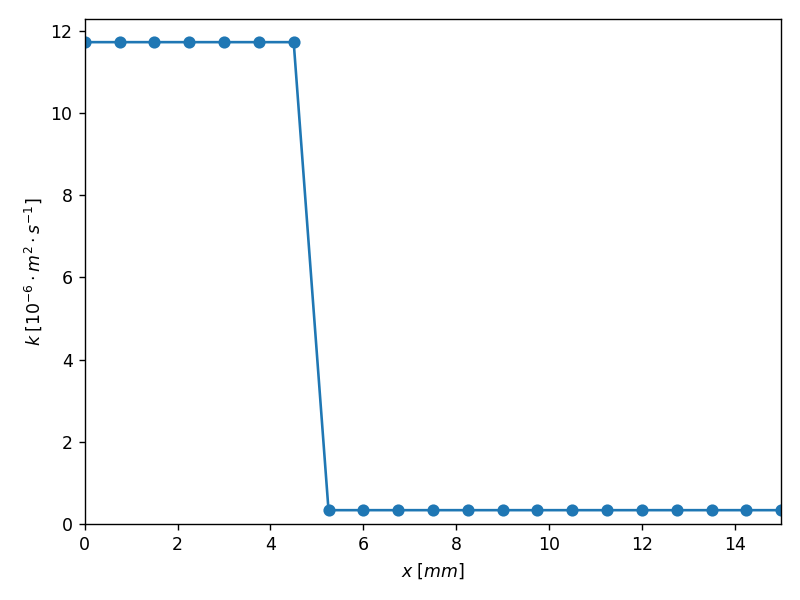

In [10]:
L_mold = 5 / 1000
L_comp = 10 / 1000

L =  L_mold + L_comp

nx = 21
dx = L / (nx - 1)

x = np.linspace(0, L, nx)

k_mold = 1.172e-5 
print("k_mold = {} m^2 / K / s".format(k_mold))

# Material data
# fiber material
k_f_parallel = 10
k_f_perp = 1.7
rho_f = 1700
c_f = 594

# matrix material
k_m = .21
rho_m = 1150
c_m = 1124

# fiber volume content
phi = .5

# fiber orientation
#theta = 0
#theta_rad = theta / 180 * np.pi

# calculate composite material properties
# thermal capacity
c_p = (c_f * rho_f * phi + c_m * rho_m * (1 - phi)) / (rho_f * phi + rho_m * (1 - phi))

# density
rho = rho_f * phi + rho_m * (1 - phi)

# fiber mass content
psi = (rho_f * phi) / (rho_f * phi + rho_m * (1 - phi))

# thermal conductivity of UD composite
#k_parallel = k_f_parallel * phi + k_m * (1 - phi)
k_perp = 1 / (phi / k_f_perp * phi + (1 - phi) / k_m)

# thermal conductivity in coorinate direction
#k_x = k_parallel * np.cos(theta_rad)**2 + k_perp * np.sin(theta_rad)**2 
#k_y = k_parallel * np.sin(theta_rad)**2 + k_perp * np.cos(theta_rad)**2 

k_comp = k_perp / rho / c_p
print("k_comp = {} m^2 / K / s".format(k_comp))

print("rho_comp = {} kg / m^3".format(rho))
print("cp_comp = {} J / kg / K".format(c_p))

k = np.zeros(nx)
idx_comp = x > L_mold
k[~idx_comp] = k_mold
k[idx_comp] = k_comp

plt.figure()
plt.plot(x*1000, k*1e6, marker="o")
plt.xlabel(r"$x \; [mm]$")
plt.ylabel(r"$k \; [10^{-6} \cdot m^2 \cdot s^{-1}]$")
plt.autoscale(axis="x", tight=True)
plt.ylim((0, None))
plt.tight_layout();

In [7]:
T0 = np.zeros(nx)
T0[:] = 20
X0 = np.zeros(np.sum(idx_comp))

dt = dx**2 / 2 / k.max()  # time-step size
#dt /= 2
print("dt = {} s".format(dt))
nt = int(cycle[-1, 0] / dt)
print("nt = {}".format(nt))
t = np.linspace(0, cycle[-1, 0], nt)

dt = 0.023997440273037546 s
nt = 925098


<IPython.core.display.Javascript object>


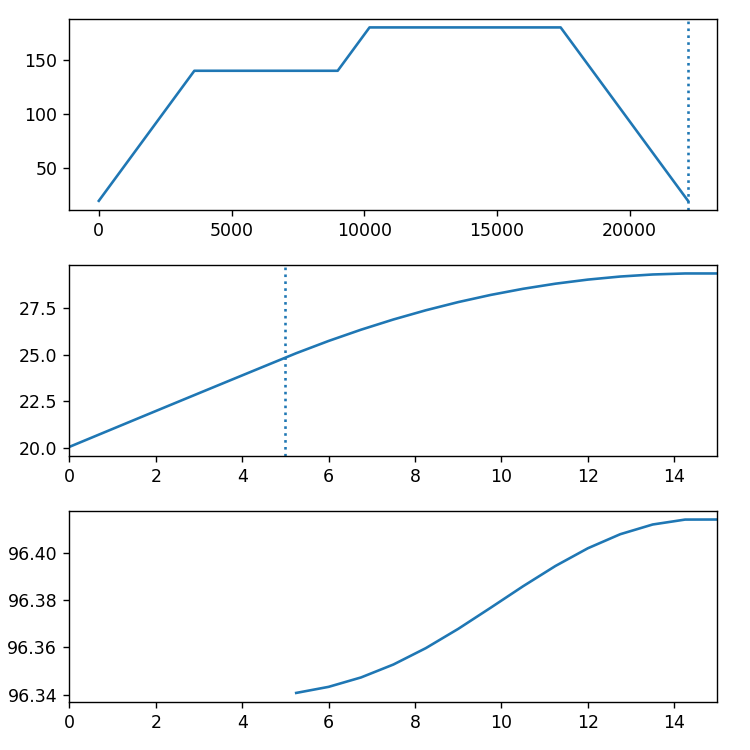

In [8]:
from scipy.integrate import ode


n_plots = 200
i_snap = nt // n_plots

fig, ax = plt.subplots(3, 1, figsize=(6, 6))
ax1, ax2, ax3 = ax

ax1.plot(cycle[:, 0], cycle[:, 1])
p1 = ax1.axvline(cycle[0, 0], ls=":")
plt.tight_layout()

plt.ion()

T = T0.copy()
X = X0.copy()
T_max = np.zeros(nt)
T_comp_outer = np.zeros(nt)
T_comp_inner = np.zeros(nt)

sigma = k[1:-1] * dt / dx**2

for n in range(nt):
    T[0] = interpol_tempcycle(t[n], cycle)
    T[1:-1] = (T[1:-1] +
               sigma * (T[2:] - 2 * T[1:-1] + T[:-2]))
    
    dXdt = reaction_model(X, T[idx_comp], Hein_2018)
    X += dXdt*dt
    
    q = dXdt*dt*Hein_2018["Hr"]*(1-psi)    
    T[idx_comp] += q/c_p
    
    T[-1] = T[-2]
    
    T_max[n] = T[idx_comp].max()
    T_comp_inner[n] = T[idx_comp][0]
    T_comp_outer[n] = T[idx_comp][-1]
    
    if n % i_snap == 0:
        p1.set_xdata(t[n])
        ax2.cla()
        ax3.cla()
        ax2.plot(x*1000, T)
        ax2.axvline(L_mold*1000, ls=":")        
        ax3.plot(x[idx_comp]*1000, X*100)
        [_ax.set_xlim((x[0]*1000, x[-1]*1000)) for _ax in [ax2, ax3]]
        fig.canvas.draw()

<IPython.core.display.Javascript object>


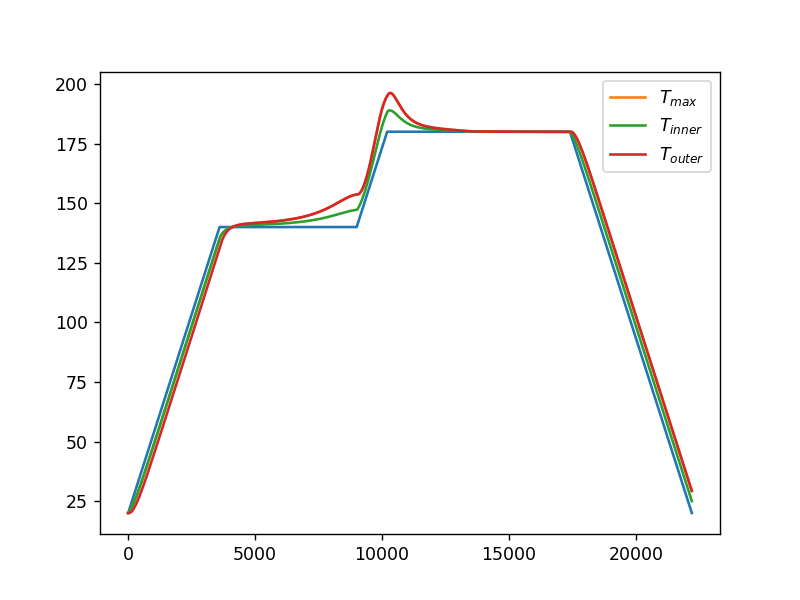

In [12]:
plt.figure()
plt.plot(cycle[:, 0], cycle[:, 1])
plt.plot(t, T_max, label=r"$T_{max}$")
plt.plot(t, T_comp_inner, label=r"$T_{inner}$")
plt.plot(t, T_comp_outer, label=r"$T_{outer}$")
plt.legend();